# PvP playout analysis

In [25]:
import sys
import os

project_root = os.path.abspath('../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Measure win rates

In [6]:

from catan.core.game import Game
from catan.core.models.player import Color, RandomPlayer


def playout(players):
    game = Game(players=players)
    game.play()
    
    return game.state.num_turns

def n_playout_steps(players, n_playouts):
    return [playout(players) for _ in range(n_playouts)]

    
n_games = 500
steps_by_player = [
    n_playout_steps([RandomPlayer(color=Color.BLUE), ], n_games),
    n_playout_steps([RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.RED)], n_games),
    n_playout_steps([RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.RED), RandomPlayer(color=Color.ORANGE)], n_games),
    n_playout_steps([RandomPlayer(color=Color.BLUE), RandomPlayer(color=Color.WHITE), RandomPlayer(color=Color.RED), RandomPlayer(color=Color.ORANGE)], n_games),
]


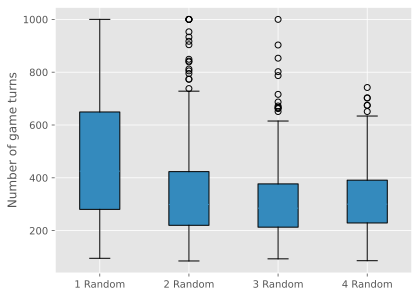

In [55]:
from matplotlib import pyplot as plt

plt.style.use("ggplot")


labels = ['1 Random', '2 Random', '3 Random', '4 Random']

fig, ax = plt.subplots()
ax.set_ylabel('Number of game turns')

bplot = ax.boxplot(
    steps_by_player,
    tick_labels=labels,
    patch_artist=True
)
ax.grid(visible=True)


plt.show()

## MCTS bots

In [61]:
from catan.bots.mcts_bot import MCTSBot

roots = []

def debug_cb(root):
    roots.append(root)

game = Game(
    players=[
        RandomPlayer(color=Color.RED, is_bot=True),
        MCTSBot(
            color=Color.BLUE,
            n_simulations=50,
            # debug=True,
            debug_cb=debug_cb
        ),
    ]
)
game.play()

<Color.BLUE: 'BLUE'>

In [63]:
from catan.analysis.player_stats import player_stats, print_player_stats

print_player_stats(
    player_stats(game)
)

[PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=2,
             longest_road=3,
             settlements=[12, 34],
             n_settlements=2,
             roads=[(12, 13), (34, 35), (11, 12), (35, 36), (33, 34), (11, 32)],
             n_roads=6,
             cities=[],
             n_cities=0),
 PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=8,
             settlements=[43, 40],
             n_settlements=2,
             roads=[(16, 18), (3, 4), (18, 40), (17, 18), (3, 12), (40, 44),
                    (43, 44), (43, 47), (21, 43), (19, 21), (45, 47), (16, 21),
                    (5, 16)],
             n_roads=13,
             cities=[4, 16],
             n_cities=2)]


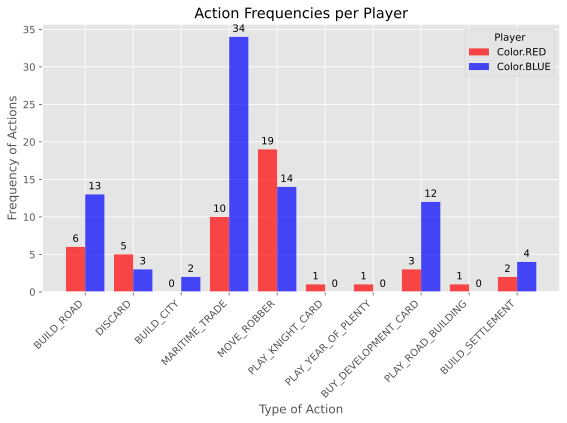

In [85]:
from catan.analysis.plot_utils import plot_action_freqs
from catan.core.models.enums import ActionType


_, _ = plot_action_freqs(
    game.state.actions,
    exclusions=[ActionType.ROLL.name, ActionType.END_TURN.name]
)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

mcts_color: Color = Color.BLUE
sim_range=np.arange(1, 12, 2)
games_per_sim=5
n_playouts = len(sim_range)
mcts_win_rates = np.zeros(n_playouts)

for node_id, n_sim in enumerate(sim_range):
    mcts_playout_wins = 0
    for n_game_in_sim in range(1, games_per_sim + 1):
        print(f'MCTS Sims {n_sim} | Playing {n_game_in_sim}/{games_per_sim} game')
        game = Game(
            players=[
                RandomPlayer(color=Color.RED, is_bot=True),
                MCTSBot(color=Color.BLUE, n_simulations=n_sim),
            ]
        )
        winner_color = game.play()

        if winner_color == mcts_color:
            mcts_playout_wins += 1

    mcts_win_rates[node_id] = mcts_playout_wins / games_per_sim

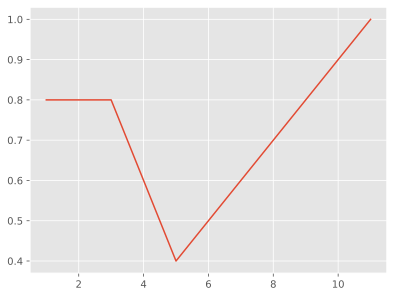

In [59]:
plt.plot(sim_range, mcts_win_rates)
plt.grid(visible=True)
plt.show()

In [60]:
from catan.analysis.player_stats import player_stats, print_player_stats


stats = player_stats(game)
print_player_stats(stats)

[PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=6,
             settlements=[14, 20, 4, 36, 23],
             n_settlements=5,
             roads=[(14, 15), (20, 22), (14, 37), (36, 37), (4, 15), (4, 5),
                    (0, 5), (5, 16), (22, 23), (6, 23)],
             n_roads=10,
             cities=[],
             n_cities=0),
 PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=3,
             longest_road=2,
             settlements=[42, 16],
             n_settlements=2,
             roads=[(40, 42), (16, 18), (41, 42), (16, 21)],
             n_roads=4,
             cities=[],
             n_cities=0)]


### MCTS Debug

### MCTS optimization

Our current MCTS scheme performance suffers, this is primarily by high branching factor -- actions possible with every step. According to thew previous analysis the average.

#### Potential moves that can be reduced

1. Initial settlement and road building, since there are 54 possible placement, we can limit only to the most promising ones.
2. Thief placement, instead of all possible tiles, place thief only on the most harmful fields for the opponents.
3. Die rolls and turn ends could be fast forwarded, no need to simulate the whole game.
4. 